# Covid-19 Turkey 

### Regression for The logistic model - Applied to the Corona Virus

In [1]:
# https://towardsdatascience.com/modeling-functions-78704936477a

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import sklearn
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from datapackage import Package

package = Package('https://datahub.io/core/covid-19/datapackage.json')

In [4]:
countries_aggregated_csv = package.get_resource('countries-aggregated_csv').read(keyed=True)
package.get_resource('countries-aggregated_csv').headers

['Date', 'Country', 'Confirmed', 'Recovered', 'Deaths']

In [5]:
# Creating a dataframe object from listoftuples
worldwide_aggregated_df = pd.DataFrame(countries_aggregated_csv)

worldwide_aggregated_df.head(3)

,Confirmed,Country,Date,Deaths,Recovered
0,0,Afghanistan,2020-01-22,0,0
1,0,Albania,2020-01-22,0,0
2,0,Algeria,2020-01-22,0,0


### Select Only Turkey

In [6]:
turkey_df = worldwide_aggregated_df[ worldwide_aggregated_df['Country'] == 'Turkey' ]
turkey_df.tail(3)

,Confirmed,Country,Date,Deaths,Recovered
12838,15679,Turkey,2020-04-01,277,333
13019,18135,Turkey,2020-04-02,356,415
13200,20921,Turkey,2020-04-03,425,484


In [59]:
turkey_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73 entries, 168 to 13200
Data columns (total 5 columns):
Confirmed    73 non-null int64
Country      73 non-null object
Date         73 non-null object
Deaths       73 non-null int64
Recovered    73 non-null int64
dtypes: int64(3), object(2)
memory usage: 3.4+ KB


In [13]:
df = turkey_df.loc[:,['Date','Confirmed']]
df = df.reset_index()
df.head()

,index,Date,Confirmed
0,168,2020-01-22,0
1,349,2020-01-23,0
2,530,2020-01-24,0
3,711,2020-01-25,0
4,892,2020-01-26,0


In [14]:
df['days'] = df.index.values
df.head(3)

,index,Date,Confirmed,days
0,168,2020-01-22,0,0
1,349,2020-01-23,0,1
2,530,2020-01-24,0,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 2 columns):
days         73 non-null int64
Confirmed    73 non-null int64
dtypes: int64(2)
memory usage: 1.2 KB


In [15]:
df = df.loc[:,['days','Confirmed']]

df.head(3)

,days,Confirmed
0,0,0
1,1,0
2,2,0


### The Logistic Model Regression 

\begin{equation*}
\text{Logistic Funtion Model:} f(x,a,b,c) = \frac{c}{1+e^{-(x-b)/a}}
\end{equation*}

In [16]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In this formula, we have the variable x that is the time and three parameters: a,b,c.<br/>

* a refers to the infection speed
* b is the day with the maximum infections occurred
* c is the total number of recorded infected people at the infection’s end

In [17]:
x = list(df.iloc[:,0])
y = list(df.iloc[:,1])

fit = curve_fit(logistic_model, x, y)

popt_log, pcov_log = curve_fit(logistic_model,x,y,p0=[2,100,100000])


In [22]:
print(popt_log)
print(pcov_log)

print('\n',fit)
print('\n',fit[0][0])

[2.87306784e+00 6.92871163e+01 2.85278422e+04]
[[3.42613580e-03 8.66188194e-03 3.74889904e+01]
 [8.66188194e-03 2.65963234e-02 1.15298407e+02]
 [3.74889904e+01 1.15298407e+02 5.11640793e+05]]

 (array([2.87306772e+00, 6.92871189e+01, 2.85278537e+04]), array([[3.42624765e-03, 8.66242999e-03, 3.74919279e+01],
       [8.66242999e-03, 2.65986184e-02, 1.15310357e+02],
       [3.74919279e+01, 1.15310357e+02, 5.11701745e+05]]))

 2.8730677181067135


In [23]:
print("parameters:", popt_log)
a_log = popt_log[0]
b_log = popt_log[1]
c_log = popt_log[2]
print("a:", a_log)
print("b:", b_log)
print("c:", c_log)

parameters: [2.87306784e+00 6.92871163e+01 2.85278422e+04]
a: 2.873067839993155
b: 69.28711625596195
c: 28527.842212325802


In [24]:
errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
errors[0]

0.058534157936837396

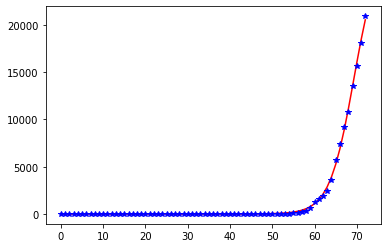

In [25]:
plt.plot(x, logistic_model(x, *popt_log), color='r', label='fit')
plt.plot(x, y, 'b*', label='data')

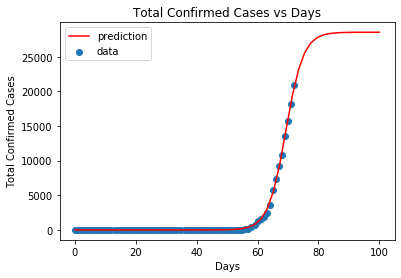

In [28]:
%matplotlib inline
plt.scatter(x, y,label='data')

plt.plot(np.linspace(0,100), logistic_model(np.linspace(0,100),*popt_log), color='r',label='prediction')

plt.title("Total Confirmed Cases vs Days")
plt.xlabel('Days')
plt.ylabel('Total Confirmed Cases')
plt.legend()
plt.show()

In [30]:
print(f'The equation of regression line is {popt_log[2]:.3f} / (1 + exp(-(x-{popt_log[1]:.3f})/{popt_log[0]:.3f}) )')

The equation of regression line is 28527.842 / (1 + exp(-(x-69.287)/2.873) )


In [152]:
#logistic_model(x , popt[0],popt[1],popt[2])

In [31]:
print(f'The equation of regression line is {popt_log[2].round(2)} / (1 + e^(-(x-{popt_log[1].round(2)})/{popt_log[0].round(2)}) )')

The equation of regression line is 28527.84 / (1 + e^(-(x-69.29)/2.87) )


### We can use the fsolve function of scipy to numerically find the root of the equation that defines the infection end day.

In [34]:
sol = int(fsolve(lambda x : logistic_model(x,*popt_log) - int(c_log),b_log))
sol

99

In [75]:
from datetime import datetime, timedelta

In [85]:
first_day = turkey_df['Date'].iloc[0]
print(first_day)

#add sol days to first_day
infection_end_day = first_day + timedelta(days = sol)
print('Infection end day: ', infection_end_day)

2020-01-22
Infection end day:  2020-04-30


## Exponential model

\begin{equation*}
\text{Exponential Funtion Model:} f(x,a,b,c) = {a e^{b(x-c)}}
\end{equation*}

In [37]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

popt_exp, pcov_exp = curve_fit(exponential_model,x,y,p0=[1,1,1])

In [42]:
print("parameters:", popt_exp)
a_exp = popt_exp[0]
b_exp = popt_exp[1]
c_exp = popt_exp[2]
print("a:", popt_exp[0])
print("b:", popt_exp[1])
print("c:", popt_exp[2])

parameters: [0.01483885 0.20566878 2.81105512]
a: 0.014838851019456584
b: 0.2056687766613
c: 2.8110551227823564


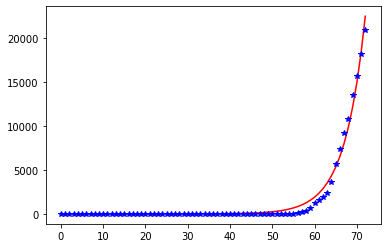

In [43]:
plt.plot(x, exponential_model(x, *popt_exp), color='r', label='fit')
plt.plot(x, y, 'b*', label='data')

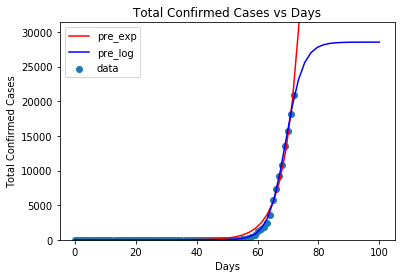

In [57]:
%matplotlib inline
plt.scatter(x, y,label='data')

plt.plot(np.linspace(0,100), exponential_model(np.linspace(0,100),*popt_exp), color='r',label='pre_exp')
plt.plot(np.linspace(0,100), logistic_model(np.linspace(0,100),*popt_log), color='b',label='pre_log')

plt.title("Total Confirmed Cases vs Days")
plt.xlabel('Days')
plt.ylabel('Total Confirmed Cases')
plt.ylim(0, c_log*1.1)
plt.legend()
plt.show()

In [95]:
y_pred_logistic = logistic_model(x,*popt_log)
y_pred_exp      = exponential_model(x,*popt_exp)
print('Logistic model MSE:', mean_squared_error(y,y_pred_logistic))
print('Exponential model MSE:', mean_squared_error(y,y_pred_exp))

Logistic model MSE: 21004.075548073386
Exponential model MSE: 221055.8402075326
